# Setup


## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account).
2. (Optional) If you would like to do the deep learning component of this tutorial, turn on the GPU with Edit->Notebook settings->Hardware accelerator->GPU
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 3, 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Delete and disconnect runtime_ and repeat steps 2-4.

**Run the following code to install Julia**

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2"
JULIA_PACKAGES="PyCall SymbolicRegression"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done
  
  julia -e 'println("Success")'
fi

Install PySR and PyTorch-Lightning:

In [ ]:
%pip install -Uq pysr pytorch_lightning

The following step is not normally required, but colab's printing is non-standard and we need to manually set it up PyJulia:


In [ ]:
from julia import Julia

julia = Julia(compiled_modules=False)
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()


Let's install the backend of PySR, and all required libraries. We will also precompile them so they are faster at startup.

**(This may take some time)**

In [ ]:
import pysr

pysr.install()


In [ ]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split


# Simple PySR example:


First, let's learn a simple function

$$2.5382 \cos(x3) + x0^2 - 2$$

In [ ]:
# Dataset
np.random.seed(0)
X = 2 * np.random.randn(100, 5)
y = 2.5382 * np.cos(X[:, 3]) + X[:, 0] ** 2 - 2


By default, we will set up 30 populations of expressions (which evolve independently except for migrations), use 4 threads, and use `"best"` for our model selection strategy:

In [ ]:
default_pysr_params = dict(
    populations=30,
    procs=4,
    model_selection="best",
)


PySR can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a [few more ways](https://github.com/MilesCranmer/PySR/pull/134) to stop execution.

**This first execution will take a bit longer to startup, as the library is JIT-compiled. The next execution will be much faster.**

In [ ]:
# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["plus", "mult"],
    unary_operators=["cos", "exp", "sin"],
    **default_pysr_params
)

model.fit(X, y)


We can print the model, which will print out all the discovered expressions:

In [ ]:
model


We can also view the SymPy format of the best expression:

In [ ]:
model.sympy()


We can also view the SymPy of any other expression in the list, using the index of it in `model.equations_`.

In [ ]:
model.sympy(2)


## Output

`model.equations_` is a Pandas DataFrame. We can export the results in various ways:

In [ ]:
model.latex()


These is also `model.sympy(), model.jax(), model.pytorch()`. All of these can take an index as input, to get the result for an arbitrary equation in the list.

We can also use `model.predict` for arbitrary equations, with the default equation being the one chosen by `model_selection`:

In [ ]:
ypredict = model.predict(X)
ypredict_simpler = model.predict(X, 2)

print("Default selection MSE:", np.power(ypredict - y, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y, 2).mean())


# Custom operators

A full list of operators is given here: https://astroautomata.com/PySR/#/operators,
but we can also use any binary or unary operator in `julia`, or define our own as arbitrary functions.

Say that we want a command to do quartic powers:

$$ y = x_0^4 - 2 $$

In [ ]:
y = X[:, 0] ** 4 - 2


We can do this by passing a string in Julia syntax.

We also define the operator in sympy, with `extra_sympy_mappings`, to enable its use in `predict`, and other export functions.

In [ ]:
model = PySRRegressor(
    niterations=5,
    populations=40,
    binary_operators=["plus", "mult"],
    unary_operators=["cos", "exp", "sin", "quart(x) = x^4"],
    extra_sympy_mappings={"quart": lambda x: x**4},
)
model.fit(X, y)


In [ ]:
model.sympy()


Since `quart` is arguably more complex than the other operators, you can also give it a different complexity, using, e.g., `complexity_of_operators={"quart": 2}` to give it a complexity of 2 (instead of the default 2). You can also define custom complexities for variables and constants (`complexity_of_variables` and `complexity_of_constants`, respectively - both take a single number).


One can also add a binary operator, with, e.g., `"myoperator(x, y) = x^2 * y"`. All Julia operators that work on scalar 32-bit floating point values are available.

Make sure that any operator you add is valid over the real line. So, e.g., you will need to define `"mysqrt(x) = sqrt(abs(x))"` to enable it for negative numbers,
or, simply have it return a very large number for bad inputs (to prevent negative input in a soft way):
`"mysqrt(x::T) where {T} = (x >= 0) ? x : T(-1e9)"` (Julia syntax for a template function of input type `T`), which will make `mysqrt(x)` return -10^9 for negative x–hurting the loss of the equation.

## Scoring

Using `model_selection="best"`selects the equation with the max score and prints it. But in practice it is best to look through all the equations manually, select an equation above some MSE threshold, and then use the score to select among that loss threshold.

Here, "score" is defined by:
$$ \text{score} = - \log(\text{loss}_i/\text{loss}_{i-1})/
(\text{complexity}_i - \text{complexity}_{i-1})$$

This scoring is motivated by the common strategy of looking for drops in the loss-complexity curve.

From Schmidt & Lipson (2009) -

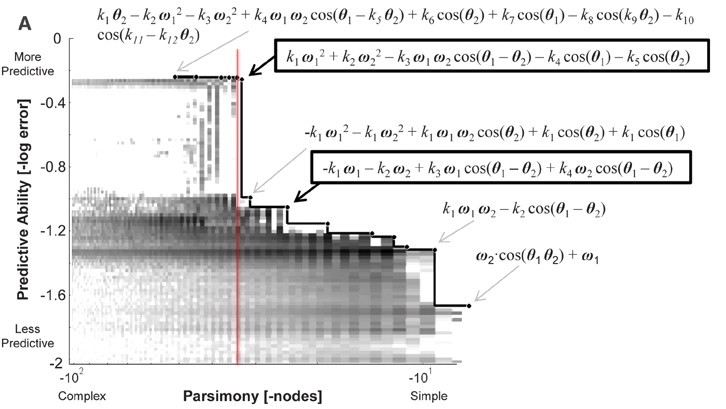

# Noise example

Here is an example with noise. Known Gaussian noise with $\sigma$ between 0.1 and 5.0. We record samples of $y$:

$$ \sigma \sim U(0.1, 5.0) $$
$$ \epsilon \sim \mathcal{N}(0, \sigma^2)$$
$$ y = 5\;\cos(3.5 x_0) - 1.3 + \epsilon.$$
We have 5 features, say. The weights change the loss function to be:
$$MSE = \sum [(y - f(x))^2*w],$$

so in this example, we can set:
$$w = 1/\sigma^2.$$

In [ ]:
np.random.seed(0)
N = 3000
upper_sigma = 5
X = 2 * np.random.rand(N, 5)
sigma = np.random.rand(N) * (5 - 0.1) + 0.1
eps = sigma * np.random.randn(N)
y = 5 * np.cos(3.5 * X[:, 0]) - 1.3 + eps


Let's look at this dataset:

In [ ]:
plt.scatter(X[:, 0], y, alpha=0.2)
plt.xlabel("$x_0$")
plt.ylabel("$y$")


Define some weights to use:

In [ ]:
weights = 1 / sigma ** 2


In [ ]:
weights[:5]


Let's run PySR again:

In [ ]:
model = PySRRegressor(
    loss="myloss(x, y, w) = w * abs(x - y)",  # Custom loss function with weights.
    niterations=20,
    populations=20,  # Use more populations
    binary_operators=["plus", "mult"],
    unary_operators=["cos"],
)
model.fit(X, y, weights=weights)


Let's see if we get similar results to the true equation

In [ ]:
model


We can also filter all equations up to 2x the most accurate equation, then select the best score from that list:

In [ ]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)


We can also use `denoise=True`, which will run the input through a Gaussian process to denoise the dataset, before fitting on it.

Let's look at the fit:

In [ ]:
plt.scatter(X[:, 0], y, alpha=0.1)
y_prediction = model.predict(X, index=best_idx)
plt.scatter(X[:, 0], y_prediction)


# High-dimensional input: Neural Nets + Symbolic Regression

In this example, let's learn a high-dimensional problem. **This will use the method proposed in our NeurIPS paper: https://arxiv.org/abs/2006.11287.**

Let's consider a time series problem:

$$ z = y^2,\quad y = \frac{1}{100} \sum(y_i),\quad y_i = x_{i0}^2 + 6 \cos(2*x_{i2})$$

Imagine our time series is 100 timesteps. That is very hard for symbolic regression, even if we impose the inductive bias of $$z=f(\sum g(x_i))$$ - it is the square of the number of possible equations!

But, as in our paper, **we can break this problem down into parts with a neural network. Then approximate the neural network with the symbolic regression!**

Then, instead of, say, $(10^9)^2=10^{18}$ equations, we only have to consider $2\times 10^9$ equations.

In [ ]:
###### np.random.seed(0)
N = 100000
Nt = 100
X = 6 * np.random.rand(N, Nt, 5) - 3
y_i = X[..., 0] ** 2 + 6 * np.cos(2 * X[..., 2])
y = np.sum(y_i, axis=1) / y_i.shape[1]
z = y**2
X.shape, y.shape


## Neural Network definition

So, as described above, let's first use a neural network with the sum inductive bias to solve this problem.

Essentially, we will learn two neural networks:
- `f`
- `g`

each defined as a multi-layer perceptron. We will sum over `g` the same way as in our equation, but we won't define the summed part beforehand.

Then, we will fit `g` and `f` **separately** using symbolic regression.

In [ ]:
hidden = 128
total_steps = 50000


def mlp(size_in, size_out, act=nn.ReLU):
    return nn.Sequential(
        nn.Linear(size_in, hidden),
        act(),
        nn.Linear(hidden, hidden),
        act(),
        nn.Linear(hidden, hidden),
        act(),
        nn.Linear(hidden, size_out),
    )


class SumNet(pl.LightningModule):
    def __init__(self):
        super().__init__()

    ########################################################
    # The same inductive bias as above!
        self.g = mlp(5, 1)
        self.f = mlp(1, 1)

    def forward(self, x):
        y_i = self.g(x)[:, :, 0]
        y = torch.sum(y_i, dim=1, keepdim=True) / y_i.shape[1]
        z = self.f(y)
        return z[:, 0]

    ########################################################

    # PyTorch Lightning bookkeeping:
    def training_step(self, batch, batch_idx):
        x, z = batch
        predicted_z = self(x)
        loss = F.mse_loss(predicted_z, z)
        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)

    def configure_optimizers(self):
        self.trainer.reset_train_dataloader()

        optimizer = torch.optim.Adam(self.parameters(), lr=self.max_lr)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.max_lr,
                total_steps=self.total_steps,
                final_div_factor=1e4,
            ),
            "interval": "step",
        }
        return [optimizer], [scheduler]


## Data bookkeeping

Put everything into PyTorch and do a train/test split:

In [ ]:
Xt = torch.tensor(X).float()
zt = torch.tensor(z).float()
X_train, X_test, z_train, z_test = train_test_split(Xt, zt, random_state=0)
train_set = TensorDataset(X_train, z_train)
train = DataLoader(train_set, batch_size=128, num_workers=2)
test_set = TensorDataset(X_test, z_test)
test = DataLoader(test_set, batch_size=256, num_workers=2)


## Train the model with PyTorch Lightning on GPUs:

Start the model:

In [ ]:
pl.seed_everything(0)
model = SumNet()
model.total_steps = total_steps
model.max_lr = 1e-2


PyTorch Lightning trainer object:

In [ ]:
trainer = pl.Trainer(max_steps=total_steps, gpus=1, benchmark=True)


Here, we fit the neural network:

In [ ]:
trainer.fit(model, train_dataloaders=train, val_dataloaders=test)


## Latent vectors of network

Let's get the input and output of the learned `g` function from the network over some random data:

In [ ]:
np.random.seed(0)
idx = np.random.randint(0, 10000, size=1000)

X_for_pysr = Xt[idx]
y_i_for_pysr = model.g(X_for_pysr)[:, :, 0]
y_for_pysr = torch.sum(y_i_for_pysr, dim=1) / y_i_for_pysr.shape[1]
z_for_pysr = zt[idx]  # Use true values.

X_for_pysr.shape, y_i_for_pysr.shape


## Learning over the network:

Now, let's fit `g` using PySR:

In [ ]:
np.random.seed(1)
tmpX = X_for_pysr.detach().numpy().reshape(-1, 5)
tmpy = y_i_for_pysr.detach().numpy().reshape(-1)
idx2 = np.random.randint(0, tmpy.shape[0], size=3000)

model = PySRRegressor(
    niterations=20,
    binary_operators=["plus", "sub", "mult"],
    unary_operators=["cos", "square", "neg"],
)
model.fit(X=tmpX[idx2], y=tmpy[idx2])


## Validation

Recall we are searching for $y_i$ above:

$$ z = y^2,\quad y = \frac{1}{100} \sum(y_i),\quad y_i = x_{i0}^2 + 6 \cos(2 x_{i2})$$

In [ ]:
model


A neural network can easily undo a linear transform, so this is fine: the network for $f$ will learn to undo the linear transform.

Then, we can learn another analytic equation for $z$.

**Now, we can compose these together to get the time series model!**

Think about what we just did: we found an analytical equation for $z$ in terms of $500$ datapoints, under the assumption that $z$ is a function of a sum of another function over an axis:

$$ z = f(\sum_i g(x_i)) $$

And we pulled out analytical copies for $g$ using symbolic regression.

# Other PySR Options

The full list of PySR parameters can be found here: https://astroautomata.com/PySR/#/api